In [2]:
import torch
import gc
import torchvision.models as models
import torch.nn as nn

import dataloader
import trainer
import visualizer

## Main Functions

Auto-reload files imported to the notebook

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


For torch dataloader to use num_workers > 0, it relies on python multiprocessing, which in windows have deadlock issues, unless the instantiation is in a .py module and the code that invokes it is wrapped inside a \__main__ section.
https://github.com/pytorch/pytorch/issues/51344

torch.Size([3, 480, 640]) torch.Size([1, 480, 640])


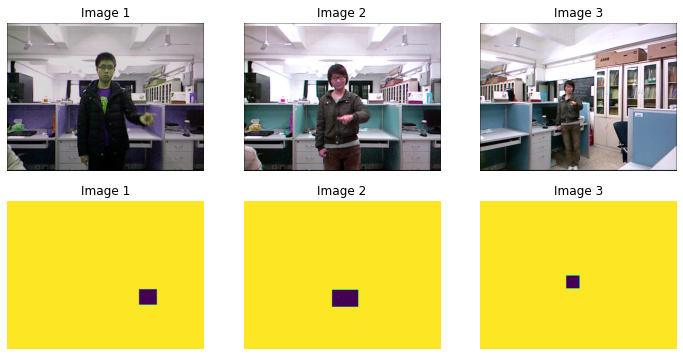

In [5]:
if __name__ == '__main__':
    loader_train, loader_val, loader_test = dataloader.main(batch_size=10, num_workers=3)

In [6]:
x, y = next(iter(loader_val))
print(x.shape, y.shape)

torch.Size([10, 3, 480, 640]) torch.Size([10, 1, 480, 640])


In [7]:
# Free cuda memory
# Reference: https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/13
def freemem():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and torch.is_tensor(obj.data):
            del obj
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

## Resnet18 Without tiles and utilizing the full dataset

Here we import the resnet18 model with pretrained weights. This gives us some good starting weights so that we don't have to train the model from scratch.

In [8]:
resnet18_notile_full = models.resnet18(pretrained=True)

From there, we replace the last layer to work with the tiles format rather than Resnet's standard classification. Lastly, we freeze all of the layers except for the newly added layer so that it can be trained individually

In [9]:
resnet18_notile_full.fc = nn.Linear(512, 480*640)
print(resnet18_notile_full.fc)

Linear(in_features=512, out_features=307200, bias=True)


##### NOTE: If you want to load the saved model then skip then section and run from the Visualize Model section

In [10]:
for param in resnet18_notile_full.parameters():
    param.require_grad = False
resnet18_notile_full.fc.requires_grad_(True)

Linear(in_features=512, out_features=307200, bias=True)

Now let's train the model!

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet18_notile_full = resnet18_notile_full.to(device)
trainer.train(resnet18_notile_full, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

Device: cuda
Training epoch 1 batch 1250/2500, train loss = 0.049565, train acc = 0.987095, recall = 0.020868, precision = nan544
validation metrics at epoch 1 batch 1250: val loss = 0.025329, val acc = 0.992115, val recall = 0.193928, val precision = 0.736325
Training epoch 1 batch 2500/2500, train loss = 0.034731, train acc = 0.990127, recall = 0.172630, precision = nan
validation metrics at epoch 1 batch 2500: val loss = 0.015300, val acc = 0.994749, val recall = 0.557900, val precision = 0.798022
Epoch 1/100 train loss = 0.034731, train acc = 0.990127, val loss = 0.015300, val acc = 0.994749
Training epoch 2 batch 1250/2500, train loss = 0.014612, train acc = 0.994518, recall = 0.508958, precision = 0.818517
validation metrics at epoch 2 batch 1250: val loss = 0.011257, val acc = 0.995795, val recall = 0.680770, val precision = 0.820084
Training epoch 2 batch 2500/2500, train loss = 0.013042, train acc = 0.995001, recall = 0.565515, precision = 0.828626
validation metrics at epoch 

([0.02532855164259672,
  0.015299901533871889,
  0.011256627651552359,
  0.01010941069573164,
  0.008319161385297775,
  0.007429252291719118,
  0.007231874875724315,
  0.00704046162776649,
  0.00699744512171795,
  0.006767714265733958,
  0.006336792814545333,
  0.006131604497010509,
  0.006159917201536397,
  0.006158836909259359,
  0.006114633864102264,
  0.006268177047992746,
  0.0059370976081117985,
  0.005854630901788672,
  0.005854877733315031,
  0.005694912152054409,
  0.005472287243853013,
  0.005478070036818584,
  0.005436932852802177,
  0.005515199716513356,
  0.005477100922726095,
  0.005356524245192607,
  0.005213700917859872,
  0.0052371876267716284,
  0.005109635869351526,
  0.0054737792676314715,
  0.005101213774954279,
  0.005102251353673637,
  0.005156350255322953,
  0.005147444141718248,
  0.005087267314083874,
  0.00512743567271779,
  0.004951674516002337,
  0.004928737621133526,
  0.004991634300289055,
  0.0049418101273477075,
  0.005087059219367802,
  0.0048544021944

Unfreeze the layers and train with the fully unfrozen model

In [12]:
for param in resnet18_notile_full.parameters():
    param.require_grad = True
trainer.train(resnet18_notile_full, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

torch.save(resnet18_notile_full.state_dict(), 'saved_models/resnet18_notile_full.model')

Training epoch 1 batch 1250/2500, train loss = 0.003555, train acc = 0.998479, recall = 0.908717, precision = 0.922367
validation metrics at epoch 1 batch 1250: val loss = 0.004829, val acc = 0.997976, val recall = 0.900010, val precision = 0.879550
Training epoch 1 batch 2500/2500, train loss = 0.003574, train acc = 0.998469, recall = 0.908537, precision = 0.921719
validation metrics at epoch 1 batch 2500: val loss = 0.004769, val acc = 0.998004, val recall = 0.902174, val precision = 0.880350
Epoch 1/100 train loss = 0.003574, train acc = 0.998469, val loss = 0.004769, val acc = 0.998004
Training epoch 2 batch 1250/2500, train loss = 0.003449, train acc = 0.998526, recall = 0.911263, precision = 0.924226
validation metrics at epoch 2 batch 1250: val loss = 0.004962, val acc = 0.997933, val recall = 0.908729, val precision = 0.869065
current_patience = 9
Training epoch 2 batch 2500/2500, train loss = 0.003483, train acc = 0.998510, recall = 0.910819, precision = 0.923656
validation me

## Model Visualizations

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


Load the model if you dont want to train it

In [14]:
resnet18_notile_full.load_state_dict(torch.load('saved_models/resnet18_notile_full.model', map_location=torch.device(device)))
resnet18_notile_full = resnet18_notile_full.to(device)

Accuracy = 99.78278279304504%
Precision = 92.98564791679382%
Recall = 86.38489246368408%


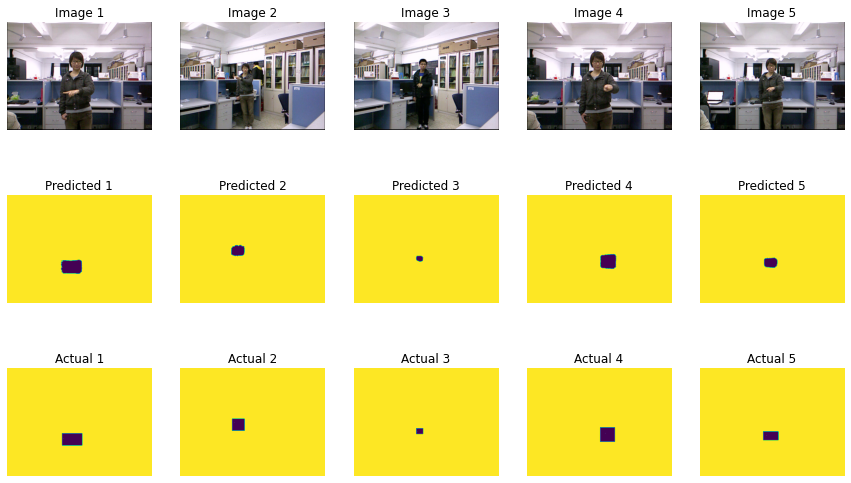

In [15]:
visualizer.visualize_model_output(loader_test, resnet18_notile_full, device=device)